# Machine Learning Trading Bot

In this Challenge, you’ll assume the role of a financial advisor at one of the top five financial advisory firms in the world. Your firm constantly competes with the other major firms to manage and automatically trade assets in a highly dynamic environment. In recent years, your firm has heavily profited by using computer algorithms that can buy and sell faster than human traders.

The speed of these transactions gave your firm a competitive advantage early on. But, people still need to specifically program these systems, which limits their ability to adapt to new data. You’re thus planning to improve the existing algorithmic trading systems and maintain the firm’s competitive advantage in the market. To do so, you’ll enhance the existing trading signals with machine learning algorithms that can adapt to new data.

## Instructions:

Use the starter code file to complete the steps that the instructions outline. The steps for this Challenge are divided into the following sections:

* Establish a Baseline Performance

* Tune the Baseline Trading Algorithm

* Evaluate a New Machine Learning Classifier

* Create an Evaluation Report

#### Establish a Baseline Performance

In this section, you’ll run the provided starter code to establish a baseline performance for the trading algorithm. To do so, complete the following steps.

Open the Jupyter notebook. Restart the kernel, run the provided cells that correspond with the first three steps, and then proceed to step four. 

1. Import the OHLCV dataset into a Pandas DataFrame.

2. Generate trading signals using short- and long-window SMA values. 

3. Split the data into training and testing datasets.

4. Use the `SVC` classifier model from SKLearn's support vector machine (SVM) learning method to fit the training data and make predictions based on the testing data. Review the predictions.

5. Review the classification report associated with the `SVC` model predictions. 

6. Create a predictions DataFrame that contains columns for “Predicted” values, “Actual Returns”, and “Strategy Returns”.

7. Create a cumulative return plot that shows the actual returns vs. the strategy returns. Save a PNG image of this plot. This will serve as a baseline against which to compare the effects of tuning the trading algorithm.

8. Write your conclusions about the performance of the baseline trading algorithm in the `README.md` file that’s associated with your GitHub repository. Support your findings by using the PNG image that you saved in the previous step.

#### Tune the Baseline Trading Algorithm

In this section, you’ll tune, or adjust, the model’s input features to find the parameters that result in the best trading outcomes. (You’ll choose the best by comparing the cumulative products of the strategy returns.) To do so, complete the following steps:

1. Tune the training algorithm by adjusting the size of the training dataset. To do so, slice your data into different periods. Rerun the notebook with the updated parameters, and record the results in your `README.md` file. Answer the following question: What impact resulted from increasing or decreasing the training window?

> **Hint** To adjust the size of the training dataset, you can use a different `DateOffset` value&mdash;for example, six months. Be aware that changing the size of the training dataset also affects the size of the testing dataset.

2. Tune the trading algorithm by adjusting the SMA input features. Adjust one or both of the windows for the algorithm. Rerun the notebook with the updated parameters, and record the results in your `README.md` file. Answer the following question: What impact resulted from increasing or decreasing either or both of the SMA windows?

3. Choose the set of parameters that best improved the trading algorithm returns. Save a PNG image of the cumulative product of the actual returns vs. the strategy returns, and document your conclusion in your `README.md` file.

#### Evaluate a New Machine Learning Classifier

In this section, you’ll use the original parameters that the starter code provided. But, you’ll apply them to the performance of a second machine learning model. To do so, complete the following steps:

1. Import a new classifier, such as `AdaBoost`, `DecisionTreeClassifier`, or `LogisticRegression`. (For the full list of classifiers, refer to the [Supervised learning page](https://scikit-learn.org/stable/supervised_learning.html) in the scikit-learn documentation.)

2. Using the original training data as the baseline model, fit another model with the new classifier.

3. Backtest the new model to evaluate its performance. Save a PNG image of the cumulative product of the actual returns vs. the strategy returns for this updated trading algorithm, and write your conclusions in your `README.md` file. Answer the following questions: Did this new model perform better or worse than the provided baseline model? Did this new model perform better or worse than your tuned trading algorithm?

#### Create an Evaluation Report

In the previous sections, you updated your `README.md` file with your conclusions. To accomplish this section, you need to add a summary evaluation report at the end of the `README.md` file. For this report, express your final conclusions and analysis. Support your findings by using the PNG images that you created.


In [26]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import hvplot.pandas
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report

---

## Establish a Baseline Performance

In this section, you’ll run the provided starter code to establish a baseline performance for the trading algorithm. To do so, complete the following steps.

Open the Jupyter notebook. Restart the kernel, run the provided cells that correspond with the first three steps, and then proceed to step four. 


### Step 1: mport the OHLCV dataset into a Pandas DataFrame.

In [27]:
# Import the OHLCV dataset into a Pandas Dataframe
ohlcv_df = pd.read_csv(
    Path("./Resources/emerging_markets_ohlcv.csv"), 
    index_col='date', 
    infer_datetime_format=True, 
    parse_dates=True
)

# Review the DataFrame
ohlcv_df.head()

,open,high,low,close,volume
date,,,,,
2015-01-21 09:30:00,23.83,23.83,23.83,23.83,100
2015-01-21 11:00:00,23.98,23.98,23.98,23.98,100
2015-01-22 15:00:00,24.42,24.42,24.42,24.42,100
2015-01-22 15:15:00,24.42,24.44,24.42,24.44,200
2015-01-22 15:30:00,24.46,24.46,24.46,24.46,200


In [28]:
# Filter the date index and close columns
signals_df = ohlcv_df.loc[:, ["close"]]

# Use the pct_change function to generate  returns from close prices
signals_df["Actual Returns"] = signals_df["close"].pct_change()

# Drop all NaN values from the DataFrame
signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns
date,,
2015-01-21 11:00:00,23.98,0.006295
2015-01-22 15:00:00,24.42,0.018349
2015-01-22 15:15:00,24.44,0.000819
2015-01-22 15:30:00,24.46,0.000818
2015-01-26 12:30:00,24.33,-0.005315


,close,Actual Returns
date,,
2021-01-22 09:30:00,33.27,-0.006866
2021-01-22 11:30:00,33.35,0.002405
2021-01-22 13:45:00,33.42,0.002099
2021-01-22 14:30:00,33.47,0.001496
2021-01-22 15:45:00,33.44,-0.000896


## Step 2: Generate trading signals using short- and long-window SMA values. 

In [45]:
# Set the short window and long window
short_window = 4
long_window = 100

# Generate the fast and slow simple moving averages (4 and 100 days, respectively)
signals_df['SMA_Fast'] = signals_df['close'].rolling(window=short_window).mean()
signals_df['SMA_Slow'] = signals_df['close'].rolling(window=long_window).mean()

signals_df = signals_df.dropna()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
date,,,,,,
2015-07-14 11:15:00,23.53,0.002556,23.4800,24.5405,1.0,0.002556
2015-07-14 11:30:00,23.54,0.000425,23.4975,24.5157,1.0,0.000425
2015-07-14 13:00:00,23.56,0.000850,23.5250,24.4911,1.0,0.000850
2015-07-14 14:00:00,23.54,-0.000849,23.5425,24.4669,-1.0,-0.000849
2015-07-14 14:45:00,23.56,0.000850,23.5500,24.4428,1.0,-0.000850


,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
date,,,,,,
2021-01-22 09:30:00,33.27,-0.006866,33.2025,30.40215,-1.0,-0.006866
2021-01-22 11:30:00,33.35,0.002405,33.2725,30.44445,1.0,-0.002405
2021-01-22 13:45:00,33.42,0.002099,33.3850,30.48745,1.0,0.002099
2021-01-22 14:30:00,33.47,0.001496,33.3775,30.53085,1.0,0.001496
2021-01-22 15:45:00,33.44,-0.000896,33.4200,30.57495,-1.0,-0.000896


In [46]:
# Initialize the new Signal column
signals_df['Signal'] = 0.0

# When Actual Returns are greater than or equal to 0, generate signal to buy stock long
signals_df.loc[(signals_df['Actual Returns'] >= 0), 'Signal'] = 1

# When Actual Returns are less than 0, generate signal to sell stock short
signals_df.loc[(signals_df['Actual Returns'] < 0), 'Signal'] = -1

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
date,,,,,,
2015-07-14 11:15:00,23.53,0.002556,23.4800,24.5405,1.0,0.002556
2015-07-14 11:30:00,23.54,0.000425,23.4975,24.5157,1.0,0.000425
2015-07-14 13:00:00,23.56,0.000850,23.5250,24.4911,1.0,0.000850
2015-07-14 14:00:00,23.54,-0.000849,23.5425,24.4669,-1.0,-0.000849
2015-07-14 14:45:00,23.56,0.000850,23.5500,24.4428,1.0,-0.000850


,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
date,,,,,,
2021-01-22 09:30:00,33.27,-0.006866,33.2025,30.40215,-1.0,-0.006866
2021-01-22 11:30:00,33.35,0.002405,33.2725,30.44445,1.0,-0.002405
2021-01-22 13:45:00,33.42,0.002099,33.3850,30.48745,1.0,0.002099
2021-01-22 14:30:00,33.47,0.001496,33.3775,30.53085,1.0,0.001496
2021-01-22 15:45:00,33.44,-0.000896,33.4200,30.57495,-1.0,-0.000896


In [47]:
signals_df['Signal'].value_counts()

 1.0    2282
-1.0    1792
Name: Signal, dtype: int64

In [48]:
# Calculate the strategy returns and add them to the signals_df DataFrame
signals_df['Strategy Returns'] = signals_df['Actual Returns'] * signals_df['Signal'].shift()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
date,,,,,,
2015-07-14 11:15:00,23.53,0.002556,23.4800,24.5405,1.0,NaN
2015-07-14 11:30:00,23.54,0.000425,23.4975,24.5157,1.0,0.000425
2015-07-14 13:00:00,23.56,0.000850,23.5250,24.4911,1.0,0.000850
2015-07-14 14:00:00,23.54,-0.000849,23.5425,24.4669,-1.0,-0.000849
2015-07-14 14:45:00,23.56,0.000850,23.5500,24.4428,1.0,-0.000850


,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
date,,,,,,
2021-01-22 09:30:00,33.27,-0.006866,33.2025,30.40215,-1.0,-0.006866
2021-01-22 11:30:00,33.35,0.002405,33.2725,30.44445,1.0,-0.002405
2021-01-22 13:45:00,33.42,0.002099,33.3850,30.48745,1.0,0.002099
2021-01-22 14:30:00,33.47,0.001496,33.3775,30.53085,1.0,0.001496
2021-01-22 15:45:00,33.44,-0.000896,33.4200,30.57495,-1.0,-0.000896


<AxesSubplot:xlabel='date'>

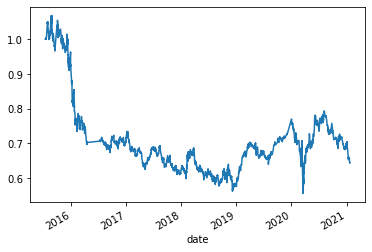

In [49]:
# Plot Strategy Returns to examine performance
(1 + signals_df['Strategy Returns']).cumprod().plot()

### Step 3: Split the data into training and testing datasets.

In [50]:
# Assign a copy of the sma_fast and sma_slow columns to a features DataFrame called X
X = signals_df[['SMA_Fast', 'SMA_Slow']].shift().dropna()

# Review the DataFrame
X.head()

,SMA_Fast,SMA_Slow
date,,
2015-07-14 11:30:00,23.4800,24.5405
2015-07-14 13:00:00,23.4975,24.5157
2015-07-14 14:00:00,23.5250,24.4911
2015-07-14 14:45:00,23.5425,24.4669
2015-07-16 11:45:00,23.5500,24.4428


In [51]:
# Create the target set selecting the Signal column and assiging it to y
y = signals_df['Signal']

# Review the value counts
y.value_counts()

 1.0    2282
-1.0    1792
Name: Signal, dtype: int64

In [52]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2015-07-14 11:30:00


In [53]:
# Select the ending period for the training data with an offset of 3 months
training_end = X.index.min() + DateOffset(months=3)

# Display the training end date
print(training_end)

2015-10-14 11:30:00


In [54]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
X_train.head()

,SMA_Fast,SMA_Slow
date,,
2015-07-14 11:30:00,23.4800,24.5405
2015-07-14 13:00:00,23.4975,24.5157
2015-07-14 14:00:00,23.5250,24.4911
2015-07-14 14:45:00,23.5425,24.4669
2015-07-16 11:45:00,23.5500,24.4428


In [55]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end+ DateOffset(hours=1):]
y_test = y.loc[training_end+ DateOffset(hours=1):]

# Review the X_test DataFrame
X_test.head()

,SMA_Fast,SMA_Slow
date,,
2015-10-14 12:30:00,22.1750,21.48439
2015-10-15 11:15:00,22.1675,21.48349
2015-10-19 12:15:00,22.1825,21.48349
2015-10-19 13:15:00,22.2525,21.48499
2015-10-19 15:45:00,22.3250,21.48689


In [56]:
# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)


### Step 4: Use the `SVC` classifier model from SKLearn's support vector machine (SVM) learning method to fit the training data and make predictions based on the testing data. Review the predictions.

In [57]:
# From SVM, instantiate SVC classifier model instance
svm_model = svm.SVC()
 
# Fit the model to the data using the training data
svm_model = svm_model.fit(X_train_scaled, y_train)
 
# Use the testing data to make the model predictions
svm_pred = svm_model.predict(X_test_scaled)

# Review the model's predicted values
svm_pred


array([ 1.,  1.,  1., ..., -1., -1., -1.])

### Step 5: Review the classification report associated with the `SVC` model predictions. 

In [58]:
# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_test, svm_pred)

# Print the classification report
print(svm_testing_report)


              precision    recall  f1-score   support

        -1.0       0.44      0.77      0.56      1718
         1.0       0.57      0.24      0.34      2195

    accuracy                           0.47      3913
   macro avg       0.50      0.50      0.45      3913
weighted avg       0.51      0.47      0.44      3913



### Step 6: Create a predictions DataFrame that contains columns for “Predicted” values, “Actual Returns”, and “Strategy Returns”.

In [59]:
# Create a new empty predictions DataFrame.

# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
predictions_df['Predicted'] = svm_pred

# Add the actual returns to the DataFrame
predictions_df['Actual Returns'] = signals_df["Actual Returns"]

# Add the strategy returns to the DataFrame
predictions_df['Strategy Returns'] = signals_df['Strategy Returns'] * predictions_df["Predicted"]

# Review the DataFrame
display(predictions_df.head())
display(predictions_df.tail())

,Predicted,Actual Returns,Strategy Returns
date,,,
2015-10-14 12:30:00,1.0,0.000903,-0.000903
2015-10-15 11:15:00,1.0,0.005415,0.005415
2015-10-19 12:15:00,1.0,0.006732,0.006732
2015-10-19 13:15:00,1.0,0.000000,0.000000
2015-10-19 15:45:00,1.0,0.002229,0.002229


,Predicted,Actual Returns,Strategy Returns
date,,,
2021-01-22 09:30:00,-1.0,-0.006866,0.006866
2021-01-22 11:30:00,-1.0,0.002405,0.002405
2021-01-22 13:45:00,-1.0,0.002099,-0.002099
2021-01-22 14:30:00,-1.0,0.001496,-0.001496
2021-01-22 15:45:00,-1.0,-0.000896,0.000896


### Step 7: Create a cumulative return plot that shows the actual returns vs. the strategy returns. Save a PNG image of this plot. This will serve as a baseline against which to compare the effects of tuning the trading algorithm.

<AxesSubplot:xlabel='date'>

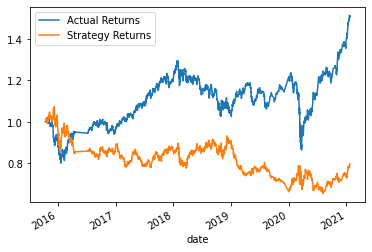

In [60]:
# Plot the actual returns versus the strategy returns
(1 + predictions_df[["Actual Returns", "Strategy Returns"]]).cumprod().plot()

---

## Tune the Baseline Trading Algorithm

## Step 6: Use an Alternative ML Model and Evaluate Strategy Returns

In this section, you’ll tune, or adjust, the model’s input features to find the parameters that result in the best trading outcomes. You’ll choose the best by comparing the cumulative products of the strategy returns.

### Step 1: Tune the training algorithm by adjusting the size of the training dataset. 

To do so, slice your data into different periods. Rerun the notebook with the updated parameters, and record the results in your `README.md` file. 

Answer the following question: What impact resulted from increasing or decreasing the training window?

I sliced the data into different periods, changing the training sample from 3 months to 1,6 and 12 months. It seemed like increasing the training window in this scenario marginally improved the accuracy at the cost of poorer recall. At 12 month training sample, there was 0% recall on selling short (-1) indicating the algo would not be able to predict when to sell, and would therefore incorrectly signal buys nearly 100% of the time. Decreasing the period to one month also had the same effect on recall without improving accuracy. This leads me to believe that 3 months is the "sweet spot" for our training period .

#### Step 2: Tune the trading algorithm by adjusting the SMA input features. 

Adjust one or both of the windows for the algorithm. Rerun the notebook with the updated parameters, and record the results in your `README.md` file. 

Answer the following question: What impact resulted from increasing or decreasing either or both of the SMA windows?

I increased the sma short window to 10 and long window to 150 and it looked like the recall for sells (-1) vastly improved (from 0.04 to 0.26) and recall of buys (1) fell (from 0.96 to 0.72). Meanwhile, precision remained about the same at the cost of a small dip in accuracy (from 0.55 to 0.52). I also then increased the short window to 50 and long window to 200, which had a similar result to increase the training window to 12 month. It seems like the model generated only buy predictions (1) since the recall for 1 was 1.00 and accuracy was 0.56 and precision and recall for -1 was 0. This is no use as a predictive model. 

### Step 3: Choose the set of parameters that best improved the trading algorithm returns. 

Save a PNG image of the cumulative product of the actual returns vs. the strategy returns, and document your conclusion in your `README.md` file.

The set of parameters that was found to best improve the returns were sma_short =10 and sma_long = 150 and the training window is 3 months. 

---

## Evaluate a New Machine Learning Classifier

In this section, you’ll use the original parameters that the starter code provided. But, you’ll apply them to the performance of a second machine learning model. 

### Step 1:  Import a new classifier, such as `AdaBoost`, `DecisionTreeClassifier`, or `LogisticRegression`. (For the full list of classifiers, refer to the [Supervised learning page](https://scikit-learn.org/stable/supervised_learning.html) in the scikit-learn documentation.)

In [20]:
# Import a new classifier from SKLearn
from sklearn.linear_model import LogisticRegression

# Initiate the model instance
LR_model = LogisticRegression()
LR_model


LogisticRegression()

### Step 2: Using the original training data as the baseline model, fit another model with the new classifier.

In [21]:
# Fit the model using the training data
LR_model = LR_model.fit(X_train_scaled,y_train)

# Use the testing dataset to generate the predictions for the new model
LR_pred = LR_model.predict(X_test_scaled)

# Review the model's predicted values
LR_pred


array([1., 1., 1., ..., 1., 1., 1.])

### Step 3: Backtest the new model to evaluate its performance. 

Save a PNG image of the cumulative product of the actual returns vs. the strategy returns for this updated trading algorithm, and write your conclusions in your `README.md` file. 

Answer the following questions: 
Did this new model perform better or worse than the provided baseline model? 
Did this new model perform better or worse than your tuned trading algorithm?

In [22]:
# Use a classification report to evaluate the model using the predictions and testing data
lr_testing_report = classification_report(y_test, LR_pred)

# Print the classification report
print(lr_testing_report)


              precision    recall  f1-score   support

        -1.0       0.44      0.36      0.39      1791
         1.0       0.56      0.64      0.59      2278

    accuracy                           0.51      4069
   macro avg       0.50      0.50      0.49      4069
weighted avg       0.50      0.51      0.51      4069



In [42]:
# Create a new empty predictions DataFrame.
predictions_lr_df = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
predictions_lr_df['Predicted'] = LR_pred

# Add the actual returns to the DataFrame
predictions_lr_df['Actual Returns'] = signals_df["Actual Returns"]

# Add the strategy returns to the DataFrame
predictions_lr_df['Strategy Returns LR'] = signals_df['Strategy Returns'] * predictions_lr_df['Predicted']

# Review the DataFrame
display(predictions_lr_df.head())
display(predictions_lr_df.tail())


,Predicted,Actual Returns,Strategy Returns LR
date,,,
2015-07-16 11:45:00,1.0,0.004669,0.004669
2015-07-17 11:30:00,1.0,-0.004225,-0.004225
2015-07-20 15:45:00,1.0,-0.001273,0.001273
2015-07-22 10:45:00,1.0,-0.011045,0.011045
2015-07-23 15:15:00,1.0,-0.008591,0.008591


,Predicted,Actual Returns,Strategy Returns LR
date,,,
2021-01-22 09:30:00,1.0,-0.006866,-0.006866
2021-01-22 11:30:00,1.0,0.002405,-0.002405
2021-01-22 13:45:00,1.0,0.002099,0.002099
2021-01-22 14:30:00,1.0,0.001496,0.001496
2021-01-22 15:45:00,1.0,-0.000896,-0.000896


<AxesSubplot:xlabel='date'>

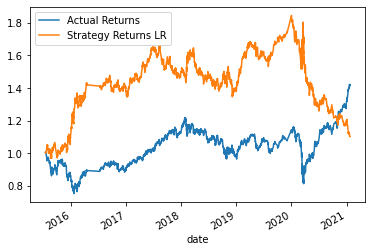

In [44]:
# Plot the actual returns versus the strategy returns
(1 + predictions_lr_df[["Actual Returns", "Strategy Returns LR"]]).cumprod().plot()